# Multiple Output Models using the Keras Functional API

Welcome to building Multi-Output DL model using tensorflow functional API! We will use the Keras functional API to train a model to predict two outputs. For this lab, you will use the **[Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)** from the **UCI machine learning repository**. It has separate datasets for red wine and white wine.

Normally, the wines are classified into one of the quality ratings specified in the attributes. Here, we will combine the two datasets to predict the wine quality and whether the wine is red or white solely from the attributes. 

We will model wine quality estimations as a regression problem and wine type detection as a binary classification problem.

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

import utils

## Load Dataset

### Pre-process the white wine dataset 

In [2]:
# URL of the white wine dataset
URI = './winequality-white.csv'

# load the dataset from the URL
white_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')


In [ ]:
print(white_df.alcohol[0])
print(white_df.alcohol[100])

8.8
9.1


### Pre-process the red wine dataset 

In [5]:
# URL of the red wine dataset
URI = './winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')


In [ ]:
print(red_df.alcohol[0])
print(red_df.alcohol[100])

9.4
10.2


### Concatenate the datasets

Next, concatenate the red and white wine dataframes.

In [8]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [ ]:
print(df.alcohol[0])
print(df.alcohol[100])

9.4
9.5


We will shuffle the dataset here.

In [ ]:
df = df.iloc[np.random.permutation(len(df))]

This will chart the quality of the wines.

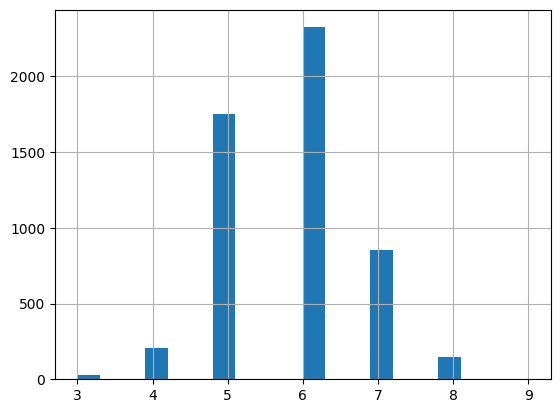

In [10]:
df['quality'].hist(bins=20);

### Imbalanced data
The plot above shows that the wine quality dataset is imbalanced. 
- Since there are very few observations with quality equal to 3, 4, 8 and 9, we can drop these observations from the dataset. 
- We will do this by removing data belonging to all classes except those > 4 and < 8.

In [11]:
# get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8)]
# reset index and drop the old one
df = df.reset_index(drop=True)

In [ ]:
print(df.alcohol[0])
print(df.alcohol[100])

9.4
10.9


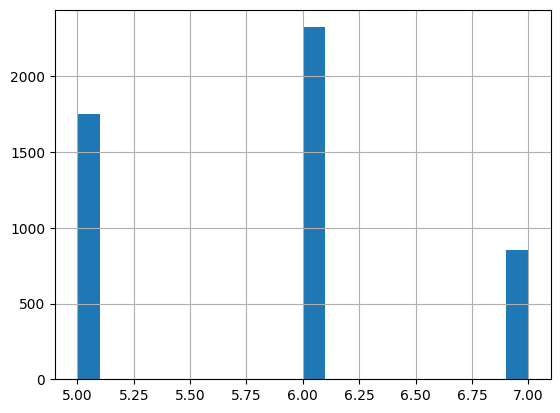

In [14]:
df['quality'].hist(bins=20);

### Train Test Split

Next, we will split the datasets into training, test and validation datasets.
- The data frame should be split 80:20 into `train` and `test` sets.
- The resulting `train` should then be split 80:20 into `train` and `val` sets.
- The `train_test_split` parameter `test_size` takes a float value that ranges between 0. and 1, and represents the proportion of the dataset that is allocated to the test set.  The rest of the data is allocated to the training set.

In [15]:
# Please do not change the random_state parameter. This is needed for grading.

train, test = train_test_split(df, test_size=0.2, random_state = 1)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 1)

Here's we will explore the training stats. We can pop the labels 'is_red' and 'quality' from the data as these will be used as the labels


In [17]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

Explore the training stats!

In [18]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.221616,1.325297,3.80000,6.40000,7.00000,7.7000,15.60000
volatile acidity,3155.0,0.338929,0.162476,0.08000,0.23000,0.29000,0.4000,1.24000
citric acid,3155.0,0.321569,0.147970,0.00000,0.25000,0.31000,0.4000,1.66000
residual sugar,3155.0,5.155911,4.639632,0.60000,1.80000,2.80000,7.6500,65.80000
chlorides,3155.0,0.056976,0.036802,0.01200,0.03800,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.388590,17.236784,1.00000,17.00000,28.00000,41.0000,131.00000
total sulfur dioxide,3155.0,115.062282,56.706617,6.00000,75.00000,117.00000,156.0000,344.00000
density,3155.0,0.994633,0.003005,0.98711,0.99232,0.99481,0.9968,1.03898
pH,3155.0,3.223201,0.161272,2.72000,3.11000,3.21000,3.3300,4.01000
sulphates,3155.0,0.534051,0.149149,0.22000,0.43000,0.51000,0.6000,1.95000


### Get the labels 

The features and labels are currently in the same dataframe.
- We will store the label columns `is_red` and `quality` separately from the feature columns.  
- The following function, `format_output`, gets these two columns from the dataframe.
- `format_output` also formats the data into numpy arrays. 

In [19]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [20]:
# format the output of the train set
train_Y = format_output(train)
# format the output of the val set
val_Y = format_output(val)
    
# format the output of the test set
test_Y = format_output(test)

Notice that after we get the labels, the `train`, `val` and `test` dataframes no longer contain the label columns, and contain just the feature columns.
- This is because we used `.pop` in the `format_output` function.

In [23]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.5,0.65,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4
3557,6.3,0.27,0.29,12.2,0.044,59.0,196.0,0.99782,3.14,0.40,8.8
3825,8.8,0.27,0.25,5.0,0.024,52.0,99.0,0.99250,2.87,0.49,11.4
1740,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8
1221,7.2,0.53,0.13,2.0,0.058,18.0,22.0,0.99573,3.21,0.68,9.9


### Normalize the data 

Next, we can normalize the data, x, using the formula:
$$x_{norm} = \frac{x - \mu}{\sigma}$$

In [24]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [25]:
# normalize the train set
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

## Define the Model

Define the model using the functional API. The base model will be 2 `Dense` layers of 128 neurons each, and have the `'relu'` activation.

In [43]:
def base_model(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation='relu')(inputs)
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation='relu')(x)
    return x

# Define output layers of the model 

We will add output layers to the base model. 
- The model will need two outputs.

One output layer will predict wine quality, which is a numeric value.
- We will define a `Dense` layer with 1 neuron.
- Since this is a regression output, the activation can be left as its default value `None`.

The other output layer will predict the wine type, which is either red `1` or not red `0` (white).
- We will define a `Dense` layer with 1 neuron.
- Since there are two possible categories, you can use a sigmoid activation for binary classification.

Define the `Model`
- Define the `Model` object, and set the following parameters:
  - `inputs`: pass in the inputs to the model as a list.
  - `outputs`: pass in a list of the outputs that you just defined: wine quality, then wine type.

In [44]:
def final_model(inputs):
    
    # get the base model
    x = base_model(inputs)
    # connect the output Dense layer for regression
    wine_quality = Dense(units=1, name='wine_quality')(x)
    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units=1, activation='sigmoid', name='wine_type')(x)
    # define the model using the input and output layers
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type])
    return model

## Compiling the Model

Next, compile the model. When setting the loss parameter of `model.compile`, we will set the loss for each of the two outputs (wine quality and wine type).

- wine_type: Since we will be performing binary classification on wine type, you should use the binary crossentropy loss function for it.  Please pass this in as a string.  
  
- wine_quality: since this is a regression output, use the mean squared error.  Please pass it in as a string, all lowercase.
  

We will also set the metric for each of the two outputs.  
- For the wine type, set it to accuracy as a string, all lowercase.
- For wine quality, use the root mean squared error. 

In [ ]:
from tensorflow.keras.metrics import RootMeanSquaredError
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model = final_model(inputs)
model.compile(optimizer=rms, 
              loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mse'
                     },
              metrics = {'wine_type' : 'accuracy',
                         'wine_quality': RootMeanSquaredError()
                       }
             )


## Training the Model 
Fit the model to the training inputs and outputs. 

In [ ]:
history = model.fit(norm_train_X, train_Y,
                    epochs = 40, validation_data=(norm_val_X, val_Y))

Epoch 1/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 25.9785 - wine_quality_loss: 25.2351 - wine_quality_mae: 4.9356 - wine_type_accuracy: 0.5680 - wine_type_loss: 0.7085 - val_loss: 18.1388 - val_wine_quality_loss: 17.4512 - val_wine_quality_mae: 4.0703 - val_wine_type_accuracy: 0.6109 - val_wine_type_loss: 0.6932
Epoch 2/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.0239 - wine_quality_loss: 11.3242 - wine_quality_mae: 3.1472 - wine_type_accuracy: 0.6837 - wine_type_loss: 0.6748 - val_loss: 6.8396 - val_wine_quality_loss: 6.2255 - val_wine_quality_mae: 2.2195 - val_wine_type_accuracy: 0.7338 - val_wine_type_loss: 0.6433
Epoch 3/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6438 - wine_quality_loss: 4.0426 - wine_quality_mae: 1.6520 - wine_type_accuracy: 0.7448 - wine_type_loss: 0.5943 - val_loss: 2.9763 - val_wine_quality_loss: 2.4793 - val_wine_quality_mae: 1.2626 - val_wine_type_accuracy: 0.7389 - val_wine_type_loss: 0.5327
Epoch 4/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3847 - wine_quality_loss: 0.3529 - wine_quality_mae: 0.4858 - wine_type_accuracy: 0.9949 - wine_type_loss: 0.0303

loss: 0.38471099734306335
wine_quality_loss: 0.3529040217399597
wine_type_loss: 0.030293498188257217
wine_quality_rmse: 0.4858468174934387
wine_type_accuracy: 0.9949302673339844


## Analyze the Model Performance

Note that the model has two outputs. The output at index 0 is quality and index 1 is wine type

So, round the quality predictions to the nearest integer.

In [52]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
print(quality_pred[0])

[5.8050537]


In [ ]:
print(type_pred[0])
print(type_pred[944])

[0.00726309]
[0.9997886]


### Plot Utilities

In [55]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [56]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(test_Y[1], np.round(type_pred), labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
    disp.plot(values_format='d');

In [57]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

### Plots for Metrics

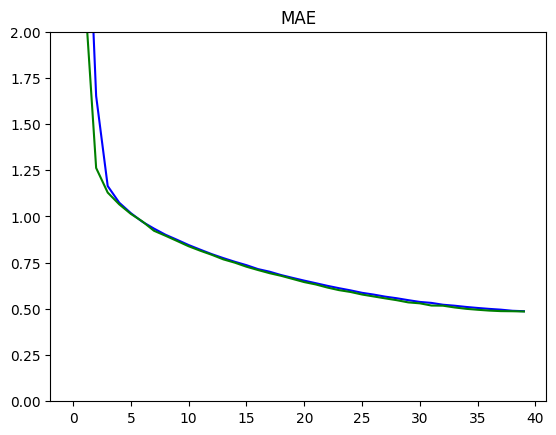

In [60]:
plot_metrics('wine_quality_mae', 'MAE', ylim=2)


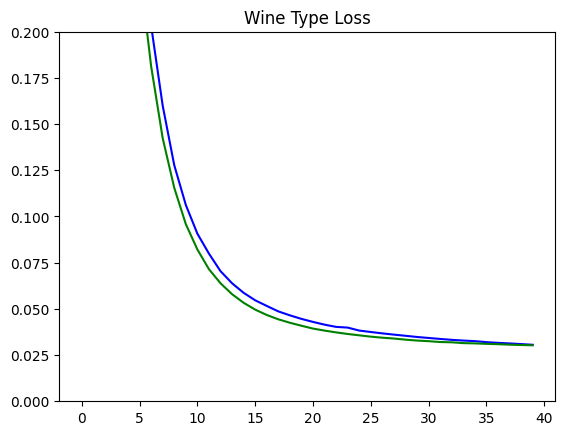

In [61]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

### Plots for Confusion Matrix

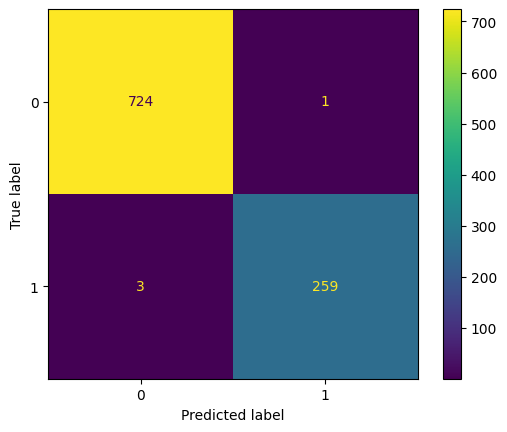

In [62]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

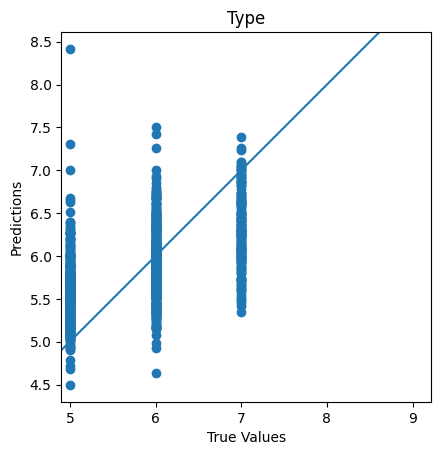

In [63]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')